In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct
from scipy.stats import binom, poisson, norm


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'


import sys

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a

In [13]:
from GetCoreData_fct import GetDensProfile
print('Creating density profile')
core = 'Dye3'

pathDens = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + '_DepthDens.txt'
pathOut = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + 'DepthDens_w_Models.txt'
pathIso = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+core+'_det.txt'

delimIso = ','
delimOut = '\t'
delimDens = '\t'

GetDensProfile(site_in = core, path_densMeas=pathDens,delim_densMeas=delimDens, path_isoMeas=pathIso, delim_isoMeas=delimIso, path_outFile=pathOut, delim_outFile=delimOut, area_in='Alphabet', zMeas_str = 'depth', densMeas_str = 'density')


Creating density profile
No density measurements. Creating purely analytical profile.


<ipython-input-13-5a468777778e>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  GetDensProfile(site_in = core, path_densMeas=pathDens,delim_densMeas=delimDens, path_isoMeas=pathIso, delim_isoMeas=delimIso, path_outFile=pathOut, delim_outFile=delimOut, area_in='Alphabet', zMeas_str = 'depth', densMeas_str = 'density')


In [14]:
from GetCoreData_fct import GetDiffProfile

print('Creating diffusion length profile')
PathDens = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/' + core + '_DepthDens.txt'
PathOut = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/' + core + '_DepthDiff.txt'
PathIso = '/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+core+'_det.txt'
DelimIso = ','
DelimOut = '\t'
DelimDens = '\t'
GetDiffProfile(site_in=core, path_outFile=PathOut, delim_outFile=DelimOut, path_densMeas=PathDens, delim_densMeas=DelimDens, path_isoMeas=PathIso, delim_isoMeas=DelimIso)


Creating diffusion length profile
No density measurements. Creating purely analytical profile.


<ipython-input-14-ec5103a54a73>:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  GetDiffProfile(site_in=core, path_outFile=PathOut, delim_outFile=DelimOut, path_densMeas=PathDens, delim_densMeas=DelimDens, path_isoMeas=PathIso, delim_isoMeas=DelimIso)


In [2]:
site = 'Crete'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


No ECM file found, setting empty df instead


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-2-d94deb82c1b0>:17: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  DataAll = GetCoreData(site, 'Alphabet')


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


[(64.725, 74.73899999999999), Text(0.5, 1.0, 'Crete')]

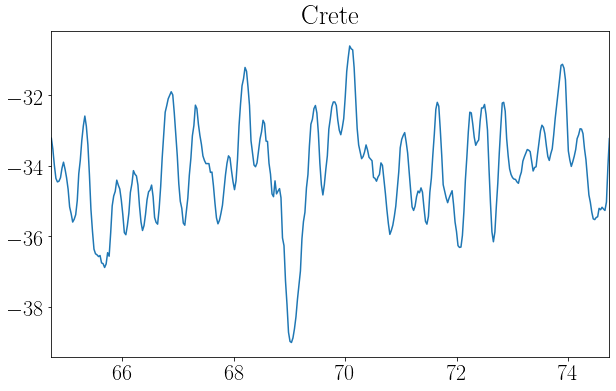

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(depth_LT,d18O_LT)
ax.set(xlim=(min(depth_LT), max(depth_LT)), title=site)

In [4]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)

inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30, transType = 'NDCT')
dep, dat, diff, Ps, Ts, pats = inst.BackDiffused_constraints()

ALT file does NOT exist. Computing ALT for core.
Entire core: 0.39-403.8130000000001 [m]

Sigma fit: 7.20
Min sigma analyt: 7.28
Starting sigma: 5.20 [cm]
6.0
Final sigma: 7.22 [cm]
Final # of peaks: 33
Delta: 0.026
Delta new: 0.013


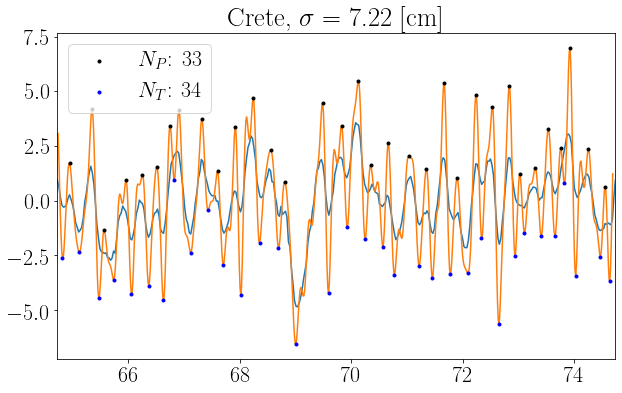

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(depth_LT,d18O_LT-np.mean(d18O_LT))
ax.plot(dep,dat)
ax.plot(dep[Ps],dat[Ps],'.', color='k', label='$N_P$: '+f'{len(Ps)}')
ax.plot(dep[Ts],dat[Ts],'.', color='b', label='$N_T$: '+f'{len(Ts)}')
ax.set(xlim=(min(depth_LT), max(depth_LT)), title=site+f', $\sigma=$ {diff*100:.2f} [cm]')
ax.legend()